# Molecule classification

In [17]:
import warnings

import rdkit
import torch
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from torch.nn import Linear
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_mean_pool as gap


warnings.filterwarnings("ignore")

print(f"pytorch: {torch.__version__}")
print(f"rdkit: {rdkit.__version__}")

pytorch: 1.8.1
rdkit: 2021.03.1


## Dataset

In the following we will use a dataset provided in the dataset collection of PyTorch Geometric ([Here you find all datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)). The Dataset comes from the MoleculeNet collection, which can be found [here](http://moleculenet.ai/datasets-1).


>"ESOL is a small dataset consisting of water solubility data for 1128 compounds. The dataset
has been used to train models that estimate solubility directly from chemical structures (as
encoded in SMILES strings). Note that these structures don’t include 3D coordinates, since
solubility is a property of a molecule and not of its particular conformers."

**>>> Machine Learning task: How are different molecules dissolving in water?**

<img src="https://www.differencebetween.com/wp-content/uploads/2018/08/Difference-Between-Solubility-and-Solubility-Product-fig-1.png" alt="solvent/solution" />

## SMILES representation and important sidenotes

<img src="https://miro.medium.com/max/283/1*8jTZAlhMMLJHExBFQdmuyA.png" alt="ibuprofen">

- Using the plain SMILES string as input is not suitable
- This will not consider the molecule structure but rather the grammar of the SMILES string
- The SMILES string can be different for a molecule, depending on the notation ( a unique molecule can have multiple SMILES strings )
- Chemical graphs however, are invariant to permutations --> Graph Neural Networks


In [5]:
data = MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

In [6]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features (32 nodes have each 9 features)
# y = labels (dimension)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  1
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(edge_attr=[68, 3], edge_index=[2, 68], smiles="OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ", x=[32, 9], y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


In [7]:
data[0].x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

![gnn_molecule](https://github.com/martin-fabbri/colab-notebooks/raw/master/pytorch-geometric/images/gnn_molecule.png)


In [9]:
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

In [10]:
data[0].y

tensor([[-0.7700]])

## Converting SMILES to RDKit molecules - Visualizing molecules

In [11]:
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

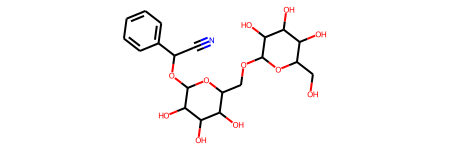

In [13]:
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [14]:
type(molecule)

rdkit.Chem.rdchem.Mol

## Implementing the Graph Neural Network

Building a Graph Neural Network works the same way as building a Convolutional Neural Network, we simple add some layers.

The GCN simply extends torch.nn.Module.
GCNConv expects:
- in_channels = Size of each input sample.
- out_channels = Size of each output sample.

We apply three convolutional layers, which means we learn the information about 3 neighbor hops. After that we apply a pooling layer to combine the information of the individual nodes, as we want to perform graph-level prediction.

Always keep in mind that different learning problems (node, edge or graph prediction) require different GNN architectures.

For example for node-level prediction you will often encounter masks. For graph-level predictions on the other hand you need to combine the node embeddings.

In [16]:
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, data.num_classes)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [18]:
# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, batch.y))       
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 3.875809669494629
Epoch 100 | Train Loss 1.2035311460494995
Epoch 200 | Train Loss 0.39399704337120056
Epoch 300 | Train Loss 0.725736141204834
Epoch 400 | Train Loss 0.7326520085334778
Epoch 500 | Train Loss 0.3107157349586487
Epoch 600 | Train Loss 0.4741998314857483
Epoch 700 | Train Loss 0.4897424876689911
Epoch 800 | Train Loss 0.5702466368675232
Epoch 900 | Train Loss 0.3855404555797577
Epoch 1000 | Train Loss 0.4637888967990875
Epoch 1100 | Train Loss 0.46807199716567993
Epoch 1200 | Train Loss 0.15512289106845856
Epoch 1300 | Train Loss 0.20495451986789703
Epoch 1400 | Train Loss 0.35119742155075073
Epoch 1500 | Train Loss 0.34338685870170593
Epoch 1600 | Train Loss 0.24466903507709503
Epoch 1700 | Train Loss 0.16341103613376617
Epoch 1800 | Train Loss 0.27212733030319214
Epoch 1900 | Train Loss 0.1517721563577652


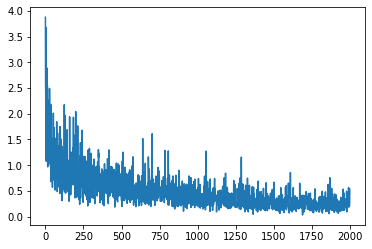

In [19]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [20]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,0.380,-0.255516
1,-3.620,-2.752561
2,-4.173,-5.283212
3,-5.190,-3.360781
4,-2.600,-2.949584
...,...,...
59,-6.860,-6.962558
60,-3.401,-2.988461
61,-2.863,-2.913759
62,-3.630,-4.594560


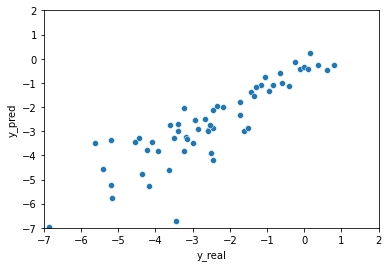

In [21]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt